> **Problem overview**

This challenge serves as final project for the "How to win a data science competition" Coursera course. In this competition you will work with a challenging time-series dataset consisting of daily sales data, kindly provided by one of the largest Russian software firms - 1C Company. 

We are asking you to predict total sales for every product and store in the next month. By solving this competition you will be able to apply and enhance your data science skills.

In [1]:
# import python standard library
import gc, itertools

# import data manipulation library
import numpy as np
import pandas as pd

# import data visualization library
import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn data preprocessing
from sklearn.preprocessing import LabelEncoder

# import xgboost model class
import xgboost as xgb

# import sklearn model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# import sklearn model evaluation regression metrics
from sklearn.metrics import mean_squared_error

In [2]:
# pandas options
pd.options.display.max_rows = 10

> **Acquiring training and testing data**

We start by acquiring the training and testing datasets into Pandas DataFrames.

In [3]:
# acquiring training and testing data
df_train = pd.read_csv('../input/sales_train.csv')
df_test = pd.read_csv('../input/test.csv')

In [4]:
# acquiring supplemental information
df_items = pd.read_csv('../input/items.csv')
df_categories = pd.read_csv('../input/item_categories.csv')
df_shops = pd.read_csv('../input/shops.csv')

In [5]:
# visualize head of the training data
df_train.head(n=5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [6]:
# visualize tail of the testing data
df_test.tail(n=5)

,ID,shop_id,item_id
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
214199,214199,45,969


In [7]:
# visualize head of the supplemental information about the items/products
df_items.head(n=5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [8]:
# visualize head of the supplemental information about the items categories
df_categories.head(n=5)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [9]:
# visualize head of the supplemental information about the shops
df_shops.head(n=5)

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [10]:
# combine training and testing dataframe
df_train['datatype'], df_test['datatype'] = 'training', 'testing'
df_train.insert(0, 'ID', np.nan)
df_test.insert(1, 'date', '01.11.2015')
df_test.insert(2, 'date_block_num', 34)
df_test.insert(df_test.shape[1] - 1, 'item_price', np.nan)
df_test.insert(df_test.shape[1] - 1, 'item_cnt_day', np.nan)
df_data = pd.concat([df_train, df_test], ignore_index=False)

> **Feature exploration, engineering and cleansing**

Here we generate descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution together with exploring some data.

In [11]:
# describe training and testing data
df_data.describe(include='all')

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datatype
count,214200.00,3150049,3.150049e+06,3.150049e+06,3.150049e+06,2.935849e+06,2.935849e+06,3150049
unique,NaN,1035,NaN,NaN,NaN,NaN,NaN,2
top,NaN,01.11.2015,NaN,NaN,NaN,NaN,NaN,training
freq,NaN,214200,NaN,NaN,NaN,NaN,NaN,2935849
mean,107099.50,NaN,1.589114e+01,3.290933e+01,1.025313e+04,8.908532e+02,1.242641e+00,NaN
...,...,...,...,...,...,...,...,...
min,0.00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01,NaN
25%,53549.75,NaN,7.000000e+00,2.200000e+01,4.510000e+03,2.490000e+02,1.000000e+00,NaN
50%,107099.50,NaN,1.500000e+01,3.100000e+01,9.461000e+03,3.990000e+02,1.000000e+00,NaN
75%,160649.25,NaN,2.400000e+01,4.700000e+01,1.572700e+04,9.990000e+02,1.000000e+00,NaN


In [12]:
# list all features type number
col_number = df_data.select_dtypes(include=['number']).columns.tolist()
print('features type number:\n items %s\n length %d' %(col_number, len(col_number)))

# list all features type object
col_object = df_data.select_dtypes(include=['object']).columns.tolist()
print('features type object:\n items %s\n length %d' %(col_object, len(col_object)))

features type number:
 items ['ID', 'date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']
 length 6
features type object:
 items ['date', 'datatype']
 length 2


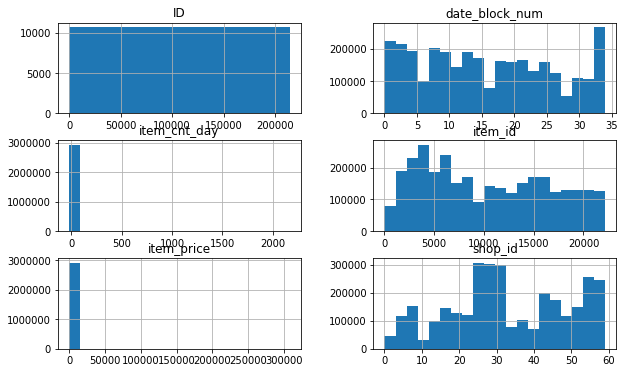

In [13]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [14]:
# feature extraction: fix the duplicated shop id
df_data.loc[df_data['shop_id'] == 0, 'shop_id'] = 57
df_data.loc[df_data['shop_id'] == 1, 'shop_id'] = 58
df_data.loc[df_data['shop_id'] == 11, 'shop_id'] = 10

In [15]:
# feature extraction: set maximum and minimum limit for item price
df_data.loc[df_data['item_price'] < 0, 'item_price'] = df_data.loc[(df_data['date_block_num'] == 4) & (df_data['shop_id'] == 32) & (df_data['item_price'] > 0), 'item_price'].median()
df_data = df_data[((df_data['item_price'] >= 0) & (df_data['item_price'] <= 100000)) | (df_data['item_price'].isna())]

In [16]:
# feature extraction: set maximum and minimum limit for number of products sold
df_data = df_data[(df_data['item_cnt_day'] <= 1000) | (df_data['item_cnt_day'].isna())]

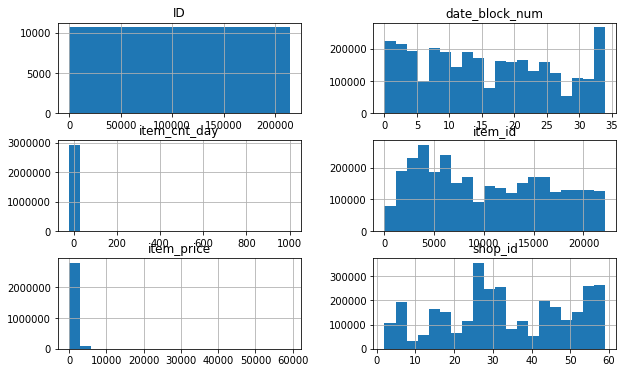

In [17]:
# feature exploration: histogram of all numeric features
_ = df_data.hist(bins=20, figsize=(10, 6))

In [18]:
# feature exploration: zero number of products sold
df_data[df_data['item_cnt_day'] == 0].head()

,ID,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,datatype


The exploratory data analysis resulting in,

* **Number of products sold:** There is no data for zero number of products sold. It is required to create the cross table of zero number of products sold in each month and merge to the main dataframe.

In [19]:
# feature extraction: cross dataframe
list_of_cross = []
for dateblocknum in df_data['date_block_num'].unique():
    shops = df_data.loc[df_data['date_block_num'] == dateblocknum, 'shop_id'].unique()
    items = df_data.loc[df_data['date_block_num'] == dateblocknum, 'item_id'].unique()
    list_of_cross.append(np.array(list(itertools.product(*[[dateblocknum], shops, items]))))
df_cross = pd.DataFrame(np.vstack(list_of_cross), columns=['date_block_num', 'shop_id', 'item_id'])

In [20]:
# describe cross dataframe
df_cross.describe(include='all')

,date_block_num,shop_id,item_id
count,1.112800e+07,1.112800e+07,1.112800e+07
mean,1.533960e+01,3.136224e+01,1.130371e+04
std,9.760412e+00,1.733254e+01,6.210934e+03
min,0.000000e+00,2.000000e+00,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.947000e+03
50%,1.500000e+01,3.100000e+01,1.138800e+04
75%,2.300000e+01,4.700000e+01,1.659200e+04
max,3.400000e+01,5.900000e+01,2.216900e+04


In [21]:
# feature extraction: block dataframe
df_block = df_data.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_price': 'mean', 'item_cnt_day': sum
}).rename(columns={'item_cnt_day': 'item_cnt_month'})

In [22]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month
count,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06,1.609123e+06
mean,1.466480e+01,3.309266e+01,1.068099e+04,7.906939e+02,2.265853e+00
std,9.542325e+00,1.646698e+01,6.238884e+03,1.532591e+03,8.466196e+00
min,0.000000e+00,2.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01
25%,6.000000e+00,2.100000e+01,5.045000e+03,1.990000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,1.049700e+04,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.800000e+01,1.606000e+04,8.985000e+02,2.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,5.099900e+04,1.644000e+03


In [23]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month
count,214200.0,214200.000000,214200.000000,0.0,214200.0
mean,34.0,31.642857,11019.398627,NaN,0.0
std,0.0,17.561933,6252.644590,NaN,0.0
min,34.0,2.000000,30.000000,NaN,0.0
25%,34.0,16.000000,5381.500000,NaN,0.0
50%,34.0,34.500000,11203.000000,NaN,0.0
75%,34.0,47.000000,16071.500000,NaN,0.0
max,34.0,59.000000,22167.000000,NaN,0.0


In [24]:
# feature extraction: merge block and cross dataframe
df_block = pd.merge(df_cross, df_block, how='left', left_on=['date_block_num', 'shop_id', 'item_id'], right_on=['date_block_num', 'shop_id', 'item_id'])

In [25]:
# feature extraction: number of products sold fillna by 0
df_block['item_cnt_month'] = df_block['item_cnt_month'].fillna(0)

In [26]:
# feature extraction: merge with supplemental information about the items/products
df_block = pd.merge(df_block, df_items, how='left', left_on='item_id', right_on='item_id')

In [27]:
# feature extraction: merge with supplemental information about the items categories
df_block = pd.merge(df_block, df_categories, how='left', left_on='item_category_id', right_on='item_category_id')

In [28]:
# feature extraction: merge with supplemental information about the shops
df_block = pd.merge(df_block, df_shops, how='left', left_on='shop_id', right_on='shop_id')

In [29]:
# feature exploration: item id
df_block['item_id'].value_counts()

15303    1628
5822     1628
18255    1628
5811     1628
16160    1628
         ... 
6996       42
17757      42
19252      42
1386       42
20863      42
Name: item_id, Length: 22169, dtype: int64

In [30]:
# feature exploration: category id
df_block['item_category_id'].value_counts()

40    2528576
55    1583333
37    1159867
31     406435
30     385121
       ...   
52        135
50         92
1          91
51         50
10         46
Name: item_category_id, Length: 84, dtype: int64

In [31]:
# feature exploration: shop id
df_block['shop_id'].value_counts()

59    239011
18    239011
58    239011
28    239011
26    239011
       ...  
8      32730
23     32730
9      25262
20     11747
36     10513
Name: shop_id, Length: 57, dtype: int64

In [32]:
# feature exploration: item id 20949
df_items.loc[df_items['item_id'] == 20949, 'item_category_id']

20949    71
Name: item_category_id, dtype: int64

In [33]:
# feature exploration: category id 71
df_items.loc[df_items['item_category_id'] == 71, 'item_id']

7149      7149
13597    13597
13598    13598
20949    20949
21788    21788
21789    21789
Name: item_id, dtype: int64

In [34]:
# feature exploration: shop id 31
df_block.loc[df_block['shop_id'] == 31, 'item_category_id'].value_counts()

40    54384
55    34035
37    24758
31     8667
30     8286
      ...  
52        3
50        2
1         2
10        1
51        1
Name: item_category_id, Length: 84, dtype: int64

In [35]:
# feature exploration: category id 40
df_block.loc[df_block['item_category_id'] == 40, 'item_id'].value_counts()

11099    1628
15833    1628
10348    1628
10340    1628
14390    1628
         ... 
13846      42
13047      42
11764      42
10310      42
17030      42
Name: item_id, Length: 5035, dtype: int64

In [36]:
# feature exploration: category id 40
df_block.loc[df_block['item_category_id'] == 40, 'shop_id'].value_counts()

59    54384
18    54384
58    54384
28    54384
26    54384
      ...  
8      9748
23     9748
9      4945
20     1904
36     1558
Name: shop_id, Length: 57, dtype: int64

In [37]:
# feature exploration: item id happened in month 33
df_block.loc[df_block['date_block_num'] == 33, 'item_id'][~df_block.loc[df_block['date_block_num'] == 33, 'item_id'].isin(df_block.loc[df_block['date_block_num'] < 33, 'item_id'])].value_counts()

1935     44
5959     44
7126     44
13299    44
17597    44
         ..
18514    44
139      44
187      44
315      44
20618    44
Name: item_id, Length: 475, dtype: int64

In [38]:
# feature exploration: item id happened in month 34
df_block.loc[df_block['date_block_num'] == 34, 'item_id'][~df_block.loc[df_block['date_block_num'] == 34, 'item_id'].isin(df_block.loc[df_block['date_block_num'] < 34, 'item_id'])].value_counts()

10203    42
17858    42
3571     42
3579     42
3627     42
         ..
7094     42
13251    42
13275    42
15330    42
14383    42
Name: item_id, Length: 363, dtype: int64

In [39]:
# feature exploration: category id happened in month 33
df_block.loc[df_block['date_block_num'] == 33, 'item_category_id'][~df_block.loc[df_block['date_block_num'] == 33, 'item_category_id'].isin(df_block.loc[df_block['date_block_num'] < 33, 'item_category_id'])].value_counts()

Series([], Name: item_category_id, dtype: int64)

In [40]:
# feature exploration: category id happened in month 34
df_block.loc[df_block['date_block_num'] == 34, 'item_category_id'][~df_block.loc[df_block['date_block_num'] == 34, 'item_category_id'].isin(df_block.loc[df_block['date_block_num'] < 34, 'item_category_id'])].value_counts()

Series([], Name: item_category_id, dtype: int64)

In [41]:
# feature exploration: shop id happened in month 33
df_block.loc[df_block['date_block_num'] == 33, 'shop_id'][~df_block.loc[df_block['date_block_num'] == 33, 'shop_id'].isin(df_block.loc[df_block['date_block_num'] < 33, 'shop_id'])].value_counts()

36    5413
Name: shop_id, dtype: int64

In [42]:
# feature exploration: shop id happened in month 34
df_block.loc[df_block['date_block_num'] == 34, 'shop_id'][~df_block.loc[df_block['date_block_num'] == 34, 'shop_id'].isin(df_block.loc[df_block['date_block_num'] < 34, 'shop_id'])].value_counts()

Series([], Name: shop_id, dtype: int64)

In [43]:
# memory clean-up
del df_categories, df_cross, df_data, df_items, df_shops
gc.collect()

26

The exploratory data analysis resulting in,

* **Item:** There are 22,166 unique items. There are always new items show up as seen from the history.
* **Category:** There are 84 unique categories.
* **Shop:** There are 57 unique shops after removed duplication from above step.

In [44]:
# feature extraction: year
df_block['year'] = df_block['date_block_num'] // 12

In [45]:
# feature extraction: month
df_block['month'] = df_block['date_block_num'] % 12

In [46]:
# feature extraction: day
day = pd.Series([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
df_block['day'] = df_block['month'].map(day)

In [47]:
# feature extraction: city
df_block.loc[df_block['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_block['city'] = df_block['shop_name'].str.split(' ').apply(lambda x: x[0])
df_block.loc[df_block['city'] == '!Якутск', 'city'] = 'Якутск'
df_block['city'].value_counts()

Москва      2397587
Тюмень       616533
Воронеж      510752
Самара       478022
Якутск       478022
             ...   
Цифровой     206281
Химки        202483
Томск        118724
Мытищи        55445
Выездная      25262
Name: city, Length: 31, dtype: int64

In [48]:
# feature extraction: city_code
df_block['city_code'] = LabelEncoder().fit_transform(df_block['city'])

In [49]:
# feature extraction: type
df_block['type'] = df_block['item_category_name'].str.split('-').apply(lambda x: x[0].strip())
df_block['type'].value_counts()

Кино                       4153431
Музыка                     2424306
Подарки                    1472572
Игры PC                     951589
Игры                        933079
                            ...   
Чистые носители (шпиль)       2576
Билеты (Цифра)                2225
Игры Android                  1115
Игры MAC                       422
PC                             179
Name: type, Length: 20, dtype: int64

In [50]:
# feature extraction: type_code
df_block['type_code'] = LabelEncoder().fit_transform(df_block['type'])

In [51]:
# feature extraction: subtype
df_block['subtype'] = df_block['item_category_name'].str.split('-').apply(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_block['subtype'].value_counts()

DVD                           2528576
CD локального производства    1583333
Blu                           1413547
Цифра                          450624
PS3                            407137
                               ...   
Гарнитуры/Наушники                179
Художественная литература         138
Путеводители                      135
Открытки                           92
Познавательная литература          50
Name: subtype, Length: 65, dtype: int64

In [52]:
# feature extraction: subtype_code
df_block['subtype_code'] = LabelEncoder().fit_transform(df_block['subtype'])

In [53]:
# describe block dataframe for month 0 - 33
df_block[df_block['date_block_num'] != 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,year,month,day,city,city_code,type,type_code,subtype,subtype_code
count,1.091380e+07,1.091380e+07,1.091380e+07,1.609123e+06,1.091380e+07,10913804,1.091380e+07,10913804,10913804,1.091380e+07,1.091380e+07,1.091380e+07,10913804,1.091380e+07,10913804,1.091380e+07,10913804,1.091380e+07
unique,NaN,NaN,NaN,NaN,NaN,21806,NaN,84,57,NaN,NaN,NaN,31,NaN,20,NaN,65,NaN
top,NaN,NaN,NaN,NaN,NaN,Игромания. Выбор редакции. Call of Duty: Moder...,NaN,Кино - DVD,"Красноярск ТЦ ""Июнь""",NaN,NaN,NaN,Москва,NaN,Кино,NaN,DVD,NaN
freq,NaN,NaN,NaN,NaN,NaN,1586,NaN,2496236,233911,NaN,NaN,NaN,2361887,NaN,4100385,NaN,2496236,NaN
mean,1.497336e+01,3.135673e+01,1.130929e+04,7.906939e+02,3.340756e-01,NaN,4.491718e+01,NaN,NaN,8.164588e-01,5.175851e+00,3.041107e+01,NaN,1.530064e+01,NaN,1.107077e+01,NaN,1.801529e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,0.000000e+00,2.000000e+00,0.000000e+00,9.000000e-02,-2.200000e+01,NaN,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00,2.800000e+01,NaN,0.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00
25%,7.000000e+00,1.600000e+01,5.976000e+03,1.990000e+02,0.000000e+00,NaN,3.700000e+01,NaN,NaN,0.000000e+00,2.000000e+00,3.000000e+01,NaN,1.000000e+01,NaN,1.100000e+01,NaN,2.000000e+00
50%,1.400000e+01,3.000000e+01,1.139100e+04,3.990000e+02,0.000000e+00,NaN,4.000000e+01,NaN,NaN,1.000000e+00,5.000000e+00,3.100000e+01,NaN,1.300000e+01,NaN,1.100000e+01,NaN,4.000000e+00
75%,2.300000e+01,4.700000e+01,1.660500e+04,8.985000e+02,0.000000e+00,NaN,5.500000e+01,NaN,NaN,1.000000e+00,8.000000e+00,3.100000e+01,NaN,2.200000e+01,NaN,1.300000e+01,NaN,3.200000e+01


In [54]:
# describe block dataframe for month 34
df_block[df_block['date_block_num'] == 34].describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_name,item_category_id,item_category_name,shop_name,year,month,day,city,city_code,type,type_code,subtype,subtype_code
count,214200.0,214200.000000,214200.000000,0.0,214200.0,214200,214200.000000,214200,214200,214200.0,214200.0,214200.0,214200,214200.000000,214200,214200.000000,214200,214200.00000
unique,NaN,NaN,NaN,NaN,NaN,5100,NaN,62,42,NaN,NaN,NaN,28,NaN,16,NaN,49,NaN
top,NaN,NaN,NaN,NaN,NaN,Настольная игра Activity (новые слова) арт. 77...,NaN,Кино - DVD,"Н.Новгород ТРЦ ""РИО""",NaN,NaN,NaN,Москва,NaN,Кино,NaN,DVD,NaN
freq,NaN,NaN,NaN,NaN,NaN,42,NaN,32340,5100,NaN,NaN,NaN,35700,NaN,53046,NaN,32340,NaN
mean,34.0,31.642857,11019.398627,NaN,0.0,NaN,46.309608,NaN,NaN,2.0,10.0,30.0,NaN,15.452381,NaN,11.042549,NaN,22.78451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
min,34.0,2.000000,30.000000,NaN,0.0,NaN,0.000000,NaN,NaN,2.0,10.0,30.0,NaN,0.000000,NaN,0.000000,NaN,0.00000
25%,34.0,16.000000,5381.500000,NaN,0.0,NaN,37.000000,NaN,NaN,2.0,10.0,30.0,NaN,10.000000,NaN,11.000000,NaN,4.00000
50%,34.0,34.500000,11203.000000,NaN,0.0,NaN,43.000000,NaN,NaN,2.0,10.0,30.0,NaN,15.000000,NaN,12.000000,NaN,16.00000
75%,34.0,47.000000,16071.500000,NaN,0.0,NaN,58.000000,NaN,NaN,2.0,10.0,30.0,NaN,22.000000,NaN,13.000000,NaN,41.00000


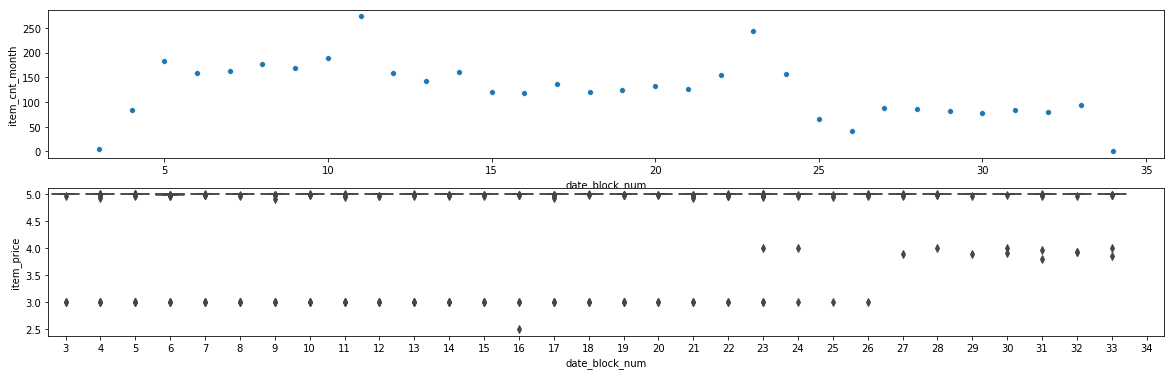

In [55]:
# feature exploration: item price and number of products sold by item id 20949
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_id'] == 20949].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_id'] == 20949], ax=axes[1])

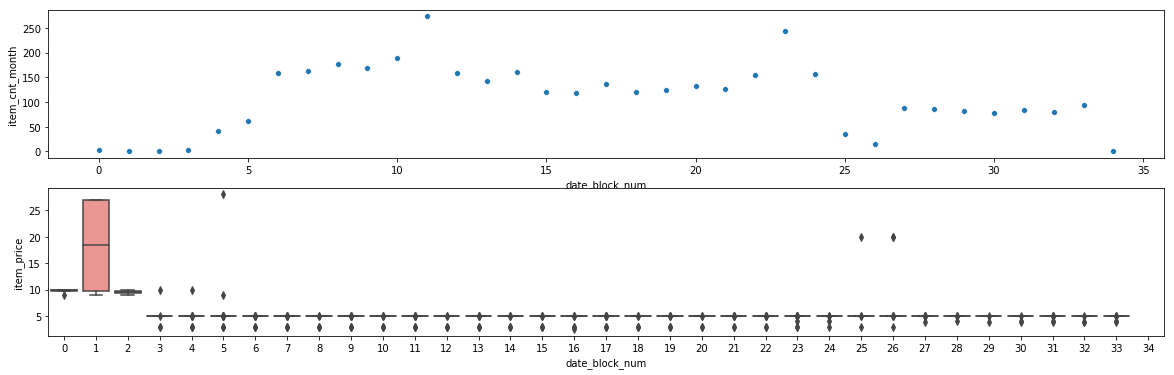

In [56]:
# feature exploration: item price and number of products sold by category id 71
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 71].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 71], ax=axes[1])

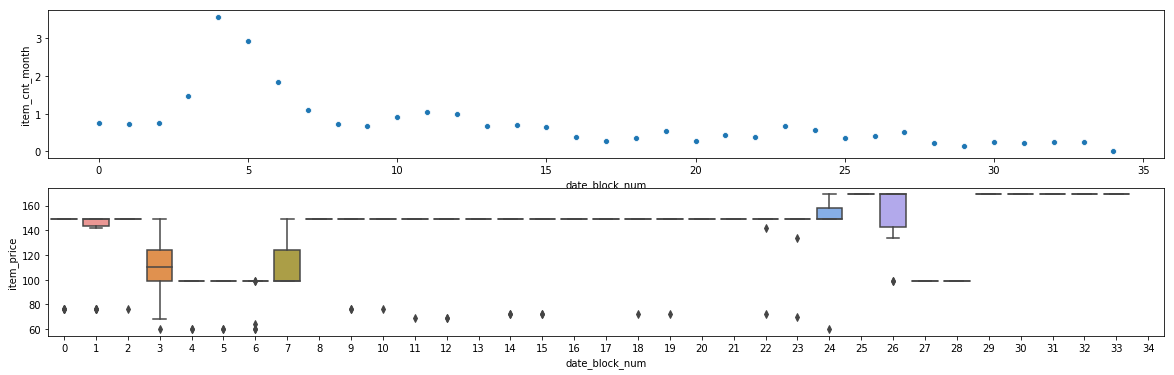

In [57]:
# feature exploration: item price and number of products sold by item id 8778
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_id'] == 8778].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_id'] == 8778], ax=axes[1])

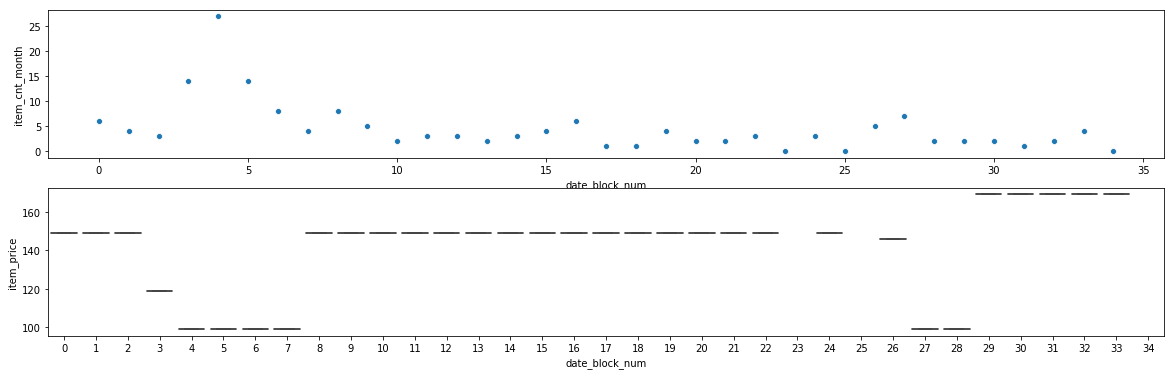

In [58]:
# feature exploration: item price and number of products sold by item id 8778 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_id'] == 8778) & (df_block['shop_id'] == 31)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_id'] == 8778) & (df_block['shop_id'] == 31)], ax=axes[1])

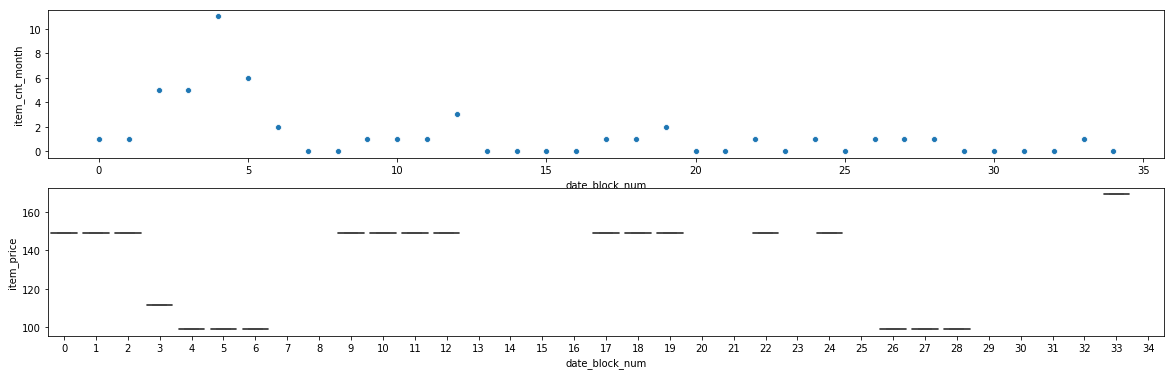

In [59]:
# feature exploration: item price and number of products sold by item id 8778 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_id'] == 8778) & (df_block['shop_id'] == 25)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_id'] == 8778) & (df_block['shop_id'] == 25)], ax=axes[1])

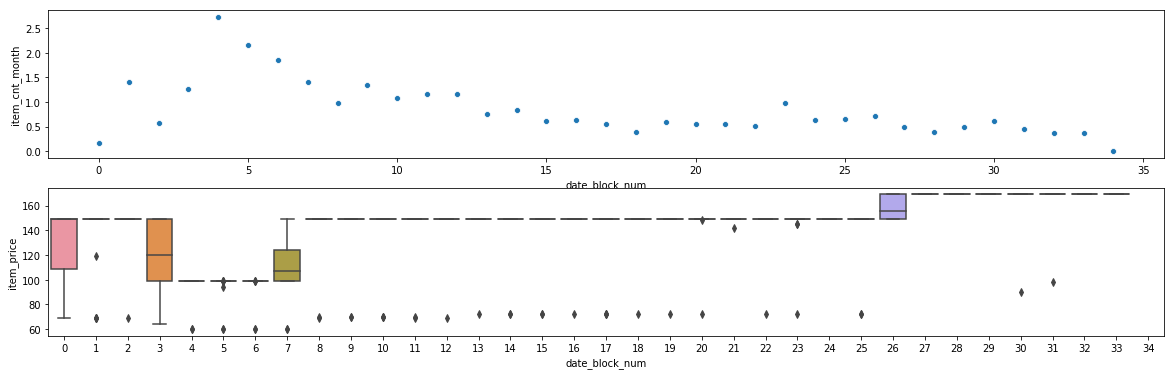

In [60]:
# feature exploration: item price and number of products sold by item id 19602
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_id'] == 19602].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_id'] == 19602], ax=axes[1])

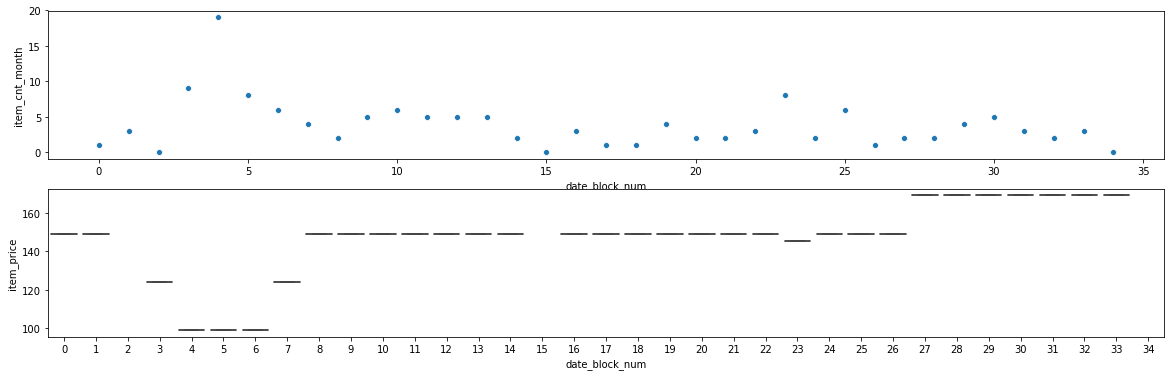

In [61]:
# feature exploration: item price and number of products sold by item id 19602 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_id'] == 19602) & (df_block['shop_id'] == 31)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_id'] == 19602) & (df_block['shop_id'] == 31)], ax=axes[1])

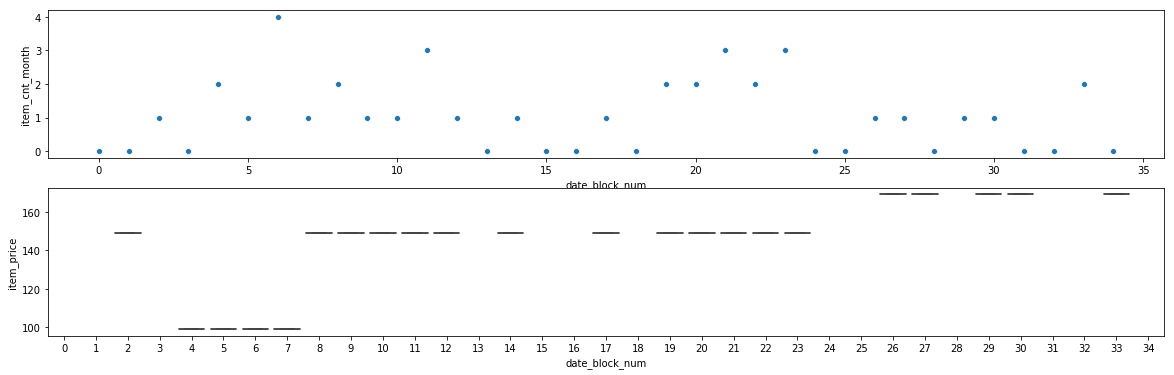

In [62]:
# feature exploration: item price and number of products sold by item id 19602 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_id'] == 19602) & (df_block['shop_id'] == 25)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_id'] == 19602) & (df_block['shop_id'] == 25)], ax=axes[1])

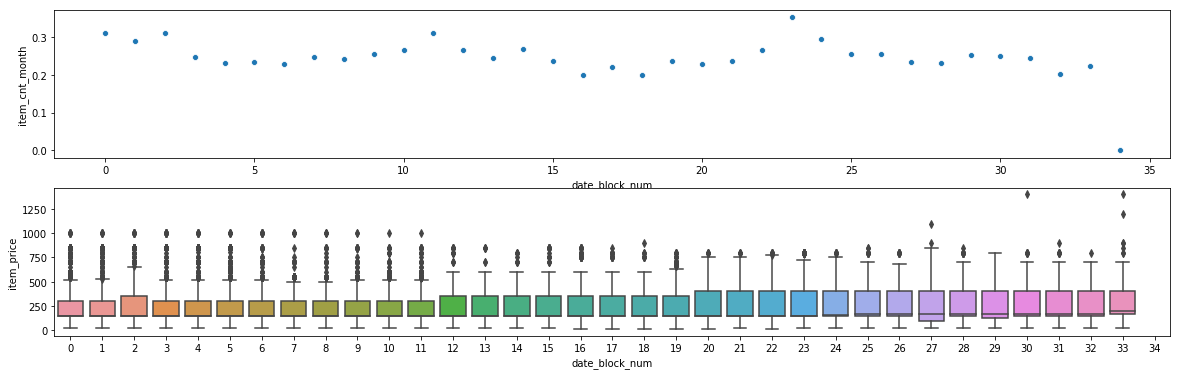

In [63]:
# feature exploration: item price and number of products sold by category id 40
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[df_block['item_category_id'] == 40].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[df_block['item_category_id'] == 40], ax=axes[1])

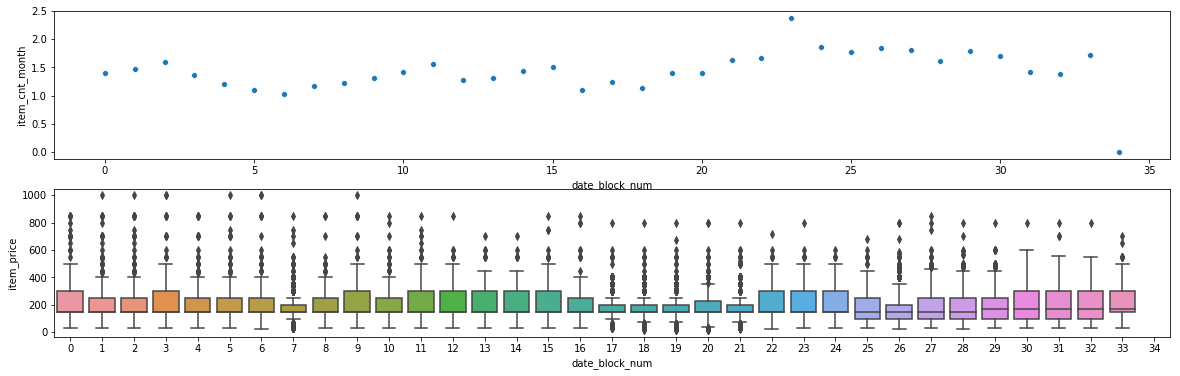

In [64]:
# feature exploration: item price and number of products sold by category id 40 and shop id 31
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 31)], ax=axes[1])

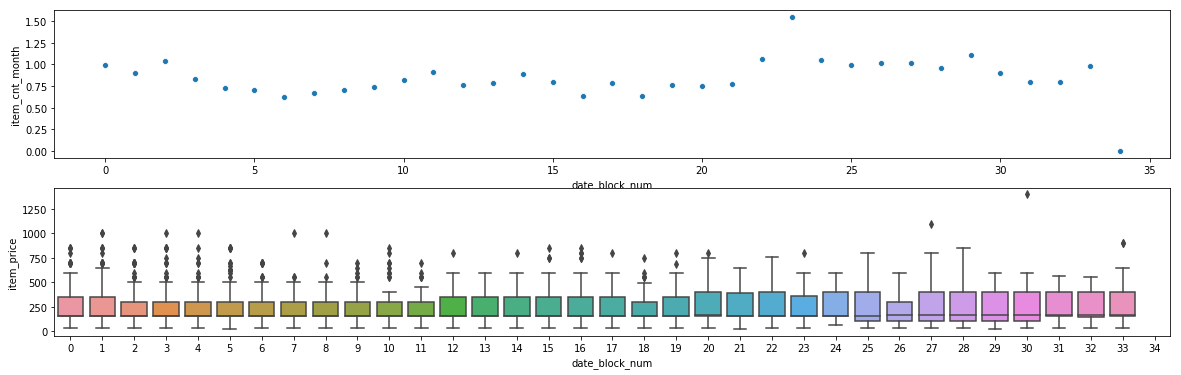

In [65]:
# feature exploration: item price and number of products sold by category id 40 and shop id 25
fig, axes = plt.subplots(figsize=(20 , 6), ncols=1, nrows=2)
axes = axes.flatten()
sns.scatterplot(x='date_block_num', y='item_cnt_month', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)].groupby(['date_block_num'], as_index=False).agg({'item_cnt_month': 'mean'}), ax=axes[0])
sns.boxplot(x='date_block_num', y='item_price', data=df_block[(df_block['item_category_id'] == 40) & (df_block['shop_id'] == 25)], ax=axes[1])

In [66]:
# memory clean-up
df_block = df_block.drop(['item_name', 'item_category_name', 'shop_name', 'city', 'type', 'subtype'], axis=1)
gc.collect()

163

The exploratory data analysis resulting in,

* **Date:** It can be seen that there are correlations between item price and number of products sold with date.

In [67]:
# feature extraction: shifted features for item price
for i in [1, 2, 3, 4, 5, 6]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_price']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_price_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [68]:
# feature extraction: statistic features for item price by item
df_block['item_price_by_item_mean'] = df_block.groupby(['item_id'])['item_price'].transform('mean').astype(np.float16)

In [69]:
# feature extraction: statistic shifted features for item price by item and date block
for i in [1, 2, 3, 4, 5, 6]: df_block['item_price_by_item_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id'])['item_price_shift' + str(i)].transform('mean').astype(np.float16)

In [70]:
# feature extraction: statistic shifted features for delta item price by item and date block
for i in [1, 2, 3, 4, 5, 6]: df_block['delta_item_price_by_item_date_mean_shift' + str(i)] = (df_block['item_price_by_item_date_mean_shift' + str(i)] - df_block['item_price_by_item_mean']) / df_block['item_price_by_item_mean']

def select_nonnull(row):
    for i in [1, 2, 3, 4, 5, 6]:
        if not(np.isnan(row['delta_item_price_by_item_date_mean_shift' + str(i)])): return row['delta_item_price_by_item_date_mean_shift' + str(i)]
    return 0
df_block['delta_item_price_by_item_date_mean_shift'] = df_block.apply(select_nonnull, axis=1)

In [71]:
# memory clean-up
df_block = df_block.drop(['item_price_by_item_date_mean_shift' + str(i) for i in [1, 2, 3, 4, 5, 6]], axis=1)
df_block = df_block.drop(['delta_item_price_by_item_date_mean_shift' + str(i) for i in [1, 2, 3, 4, 5, 6]], axis=1)
gc.collect()

245

The exploratory data analysis resulting in,

* **Price:** As seen the correlations between item price and number of products sold above, the item price shift feature and select non-null number is applied.

In [72]:
# feature extraction: set maximum and minimum limit for number of products sold
df_block['item_cnt_month'] = df_block['item_cnt_month'].clip(0 ,20)

In [73]:
# feature extraction: shifted features for number of products sold
for i in [1, 2, 3, 6, 12]:
    shifted = df_block[['date_block_num', 'shop_id', 'item_id', 'item_cnt_month']].copy(deep=True)
    shifted.columns = ['date_block_num', 'shop_id','item_id', 'item_cnt_month_shift' + str(i)]
    shifted['date_block_num'] = shifted['date_block_num'] + i
    df_block = pd.merge(df_block, shifted, how='left', on=['date_block_num', 'shop_id', 'item_id'])

In [74]:
# feature extraction: statistic shifted features for number of products sold by date block
for i in [1]: df_block['item_cnt_month_by_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [75]:
# feature extraction: statistic shifted features for number of products sold by item and date block
for i in [1, 2, 3, 6, 12]: df_block['item_cnt_month_by_item_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [76]:
# feature extraction: statistic shifted features for number of products sold by category and date block
for i in [1, 2, 3, 6, 12]: df_block['item_cnt_month_by_category_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [77]:
# feature extraction: statistic shifted features for number of products sold by shop and date block
for i in [1, 2, 3, 6, 12]: df_block['item_cnt_month_by_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [78]:
# feature extraction: statistic shifted features for number of products sold by city and date block
for i in [1]: df_block['item_cnt_month_by_city_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'city_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [79]:
# feature extraction: statistic shifted features for number of products sold by item, city and date block
for i in [1]: df_block['item_cnt_month_by_item_city_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_id', 'city_code'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

In [80]:
# feature extraction: statistic shifted features for number of products sold by category, shop and date block
for i in [1]: df_block['item_cnt_month_by_category_shop_date_mean_shift' + str(i)] = df_block.groupby(['date_block_num', 'item_category_id', 'shop_id'])['item_cnt_month_shift' + str(i)].transform('mean').astype(np.float16)

The exploratory data analysis resulting in,

* **Number of products sold:** The shift feature for number of products sold are created with multiple grouping combinations.

In [81]:
# feature extraction: first sale
df_block['first_sale_item'] = (df_block['date_block_num'] - df_block.groupby(['item_id'])['date_block_num'].transform('min')).astype(np.int16)
df_block['first_sale_item_shop'] = (df_block['date_block_num'] - df_block.groupby(['item_id', 'shop_id'])['date_block_num'].transform('min')).astype(np.int16)

In [82]:
# feature extraction: number of products sold for first sale by category
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id'])

In [83]:
# feature extraction: number of products sold for first sale by category for month onwards
for i in [12, 18, 24, 30]:
    list_of_first = []
    for dateblocknum in df_block['date_block_num'].unique():
        df_first = df_block[(df_block['date_block_num'] >= i) & (df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id'], as_index=False).agg({'item_cnt_month': 'mean'})
        df_first.insert(0, 'date_block_num', dateblocknum)
        list_of_first.append(df_first)
    df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_first_month' + str(i) + 'onwards'})
    df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id'])

In [84]:
# feature extraction: number of products sold for first sale by category and shop
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'shop_id'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_shop_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'shop_id'])

In [85]:
# feature extraction: number of products sold for first sale by category and shop for month onwards
for i in [12, 18, 24, 30]:
    list_of_first = []
    for dateblocknum in df_block['date_block_num'].unique():
        df_first = df_block[(df_block['date_block_num'] >= i) & (df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'shop_id'], as_index=False).agg({'item_cnt_month': 'mean'})
        df_first.insert(0, 'date_block_num', dateblocknum)
        list_of_first.append(df_first)
    df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_shop_first_month' + str(i) + 'onwards'})
    df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'shop_id'])

In [86]:
# feature extraction: number of products sold for first sale by category and city
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'city_code'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_city_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'city_code'])

In [87]:
# feature extraction: number of products sold for first sale by category and city for month onwards
for i in [12, 18, 24, 30]:
    list_of_first = []
    for dateblocknum in df_block['date_block_num'].unique():
        df_first = df_block[(df_block['date_block_num'] >= i) & (df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'city_code'], as_index=False).agg({'item_cnt_month': 'mean'})
        df_first.insert(0, 'date_block_num', dateblocknum)
        list_of_first.append(df_first)
    df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_city_first_month' + str(i) + 'onwards'})
    df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'city_code'])

In [88]:
# feature extraction: number of products sold for first sale by category and type
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'type_code'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_type_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'type_code'])

In [89]:
# feature extraction: number of products sold for first sale by category and subtype
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['item_category_id', 'subtype_code'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_category_subtype_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'item_category_id', 'subtype_code'])

In [90]:
# feature extraction: number of products sold for first sale by shop
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['shop_id'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_shop_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'shop_id'])

In [91]:
# feature extraction: number of products sold for first sale by city
list_of_first = []
for dateblocknum in df_block['date_block_num'].unique():
    df_first = df_block[(df_block['date_block_num'] < dateblocknum) & (df_block['first_sale_item'] == 0)].groupby(['city_code'], as_index=False).agg({'item_cnt_month': 'mean'})
    df_first.insert(0, 'date_block_num', dateblocknum)
    list_of_first.append(df_first)
df_first = pd.concat(list_of_first, ignore_index=True).rename(columns={'item_cnt_month': 'item_cnt_month_by_city_first'})
df_block = pd.merge(df_block, df_first, how='left', on=['date_block_num', 'city_code'])

The exploratory data analysis resulting in,

* **First sale:** There are multiple items sale at first time which shfit features are not covered. The mean features group by category, type, subtype, shop and city are created.

In [92]:
# feature extraction: drop first 12 months records
df_block = df_block[df_block['date_block_num'] > 11]

In [93]:
# feature extraction: fillna with 0
col_fillnas = df_block.columns[df_block.isna().any()].tolist()
df_block[col_fillnas] = df_block[col_fillnas].fillna(0)

In [94]:
# memory clean-up
col_floats = [col for col in df_block.columns if df_block[col].dtypes == 'float64']
col_ints = [col for col in df_block.columns if df_block[col].dtypes == 'int64']
df_block[col_floats] = df_block[col_floats].astype(np.float16)
df_block[col_ints] = df_block[col_ints].astype(np.int16)
del df_first, list_of_first
gc.collect()

28

After extracting all features, it is required to convert category features to numerics features, a format suitable to feed into our Machine Learning models.

In [95]:
# describe block dataframe
df_block.describe(include='all')

,date_block_num,shop_id,item_id,item_price,item_cnt_month,item_category_id,year,month,day,city_code,type_code,subtype_code,item_price_shift1,item_price_shift2,item_price_shift3,item_price_shift4,item_price_shift5,item_price_shift6,item_price_by_item_mean,delta_item_price_by_item_date_mean_shift,item_cnt_month_shift1,item_cnt_month_shift2,item_cnt_month_shift3,item_cnt_month_shift6,item_cnt_month_shift12,item_cnt_month_by_date_mean_shift1,item_cnt_month_by_item_date_mean_shift1,item_cnt_month_by_item_date_mean_shift2,item_cnt_month_by_item_date_mean_shift3,item_cnt_month_by_item_date_mean_shift6,item_cnt_month_by_item_date_mean_shift12,item_cnt_month_by_category_date_mean_shift1,item_cnt_month_by_category_date_mean_shift2,item_cnt_month_by_category_date_mean_shift3,item_cnt_month_by_category_date_mean_shift6,item_cnt_month_by_category_date_mean_shift12,item_cnt_month_by_shop_date_mean_shift1,item_cnt_month_by_shop_date_mean_shift2,item_cnt_month_by_shop_date_mean_shift3,item_cnt_month_by_shop_date_mean_shift6,item_cnt_month_by_shop_date_mean_shift12,item_cnt_month_by_city_date_mean_shift1,item_cnt_month_by_item_city_date_mean_shift1,item_cnt_month_by_category_shop_date_mean_shift1,first_sale_item,first_sale_item_shop,item_cnt_month_by_category_first,item_cnt_month_by_category_first_month12onwards,item_cnt_month_by_category_first_month18onwards,item_cnt_month_by_category_first_month24onwards,item_cnt_month_by_category_first_month30onwards,item_cnt_month_by_category_shop_first,item_cnt_month_by_category_shop_first_month12onwards,item_cnt_month_by_category_shop_first_month18onwards,item_cnt_month_by_category_shop_first_month24onwards,item_cnt_month_by_category_shop_first_month30onwards,item_cnt_month_by_category_city_first,item_cnt_month_by_category_city_first_month12onwards,item_cnt_month_by_category_city_first_month18onwards,item_cnt_month_by_category_city_first_month24onwards,item_cnt_month_by_category_city_first_month30onwards,item_cnt_month_by_category_type_first,item_cnt_month_by_category_subtype_first,item_cnt_month_by_shop_first,item_cnt_month_by_city_first
count,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.0,6639294.0,6639294.0,6639294.0,6639294.0,6639294.0,6639294.000,6.639294e+06,6639294.0,6639294.0,6639294.0,6639294.0,6639294.0,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.00,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06,6639294.00,6.639294e+06,6.639294e+06,6.639294e+06,6.639294e+06
mean,2.199694e+01,3.187348e+01,1.126362e+04,NaN,NaN,4.495836e+01,1.406636e+00,5.117307e+00,3.039279e+01,1.553656e+01,1.099628e+01,1.953048e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.307342e+01,1.225471e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,6.461452e+00,1.726781e+01,6.271893e+03,NaN,0.0,1.573942e+01,4.912059e-01,3.388494e+00,8.900391e-01,7.995480e+00,2.978096e+00,2.084926e+01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.447809e+00,8.390482e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
min,1.200000e+0

In [96]:
# verify dtypes object
df_block.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 65 columns):
date_block_num                                          int16
shop_id                                                 int16
item_id                                                 int16
item_price                                              float16
item_cnt_month                                          float16
item_category_id                                        int16
year                                                    int16
month                                                   int16
day                                                     int16
city_code                                               int16
type_code                                               int16
subtype_code                                            int16
item_price_shift1                                       float16
item_price_shift2                                       float16
item

> **Analyze and identify patterns by visualizations**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilize the Seaborn plotting package which allows us to plot very conveniently as follows.

The Pearson Correlation plot can tell us the correlation between features with one another. If there is no strongly correlated between features, this means that there isn't much redundant or superfluous data in our training data. This plot is also useful to determine which features are correlated to the observed value.

The pairplots is also useful to observe the distribution of the training data from one feature to the other.

The pivot table is also another useful method to observe the impact between features.

> **Model, predict and solve the problem**

Now, it is time to feed the features to Machine Learning models.

In [97]:
# select the important features
x = df_block[(df_block['first_sale_item'] != 0) & (df_block['date_block_num'] >= 30) & (df_block['date_block_num'] <= 33)].drop(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_category_id', 'year', 'month', 'day', 'city_code', 'type_code', 'subtype_code'] + [col for col in df_block.columns if col.startswith('item_price')], axis=1)
y = df_block.loc[(df_block['first_sale_item'] != 0) & (df_block['date_block_num'] >= 30) & (df_block['date_block_num'] <= 33), 'item_cnt_month']

In [98]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, random_state=58, test_size=0.25)

In [99]:
# memory clean-up
del x, y
gc.collect()

10

In [100]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=8, learning_rate=0.3, n_estimators=500, objective='reg:linear', booster='gbtree', gamma=0.1, min_child_weight=300, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=10, verbose=False, callbacks=[xgb.callback.print_evaluation(period=10)])

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate).clip(0 ,20)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:31:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.898078	validation_1-rmse:0.869451
[10]	validation_0-rmse:0.6823	validation_1-rmse:0.67568
[20]	validation_0-rmse:0.67059	validation_1-rmse:0.66666
[30]	validation_0-rmse:0.664394	validation_1-rmse:0.662283
[40]	validation_0-rmse:0.658037	validation_1-rmse:0.658288
[50]	validation_0-rmse:0.65462	validation_1-rmse:0.655831
[60]	validation_0-rmse:0.649953	validation_1-rmse:0.653438
[70]	validation_0-rmse:0.647006	validation_1-rmse:0.651715
[80]	validation_0-rmse:0.643502	validation_1-rmse:0.649099
[90]	validation_0-rmse:0.63998	validation_1-rmse:0.6475
[100]	validation_0-rmse:0.637455	validation_1-rmse:0.646318
[110]	validation_0-rmse:0.635412	validation_1-rmse:0.64601
[120]	validation_0-rmse:0.633583	validation_1-rmse:0.645395
[130]	validation_0-rmse:0.630954	validation_1-rmse:0.643856
[140]	validation_0-rmse:0.627918	validation_1-rmse:0.6

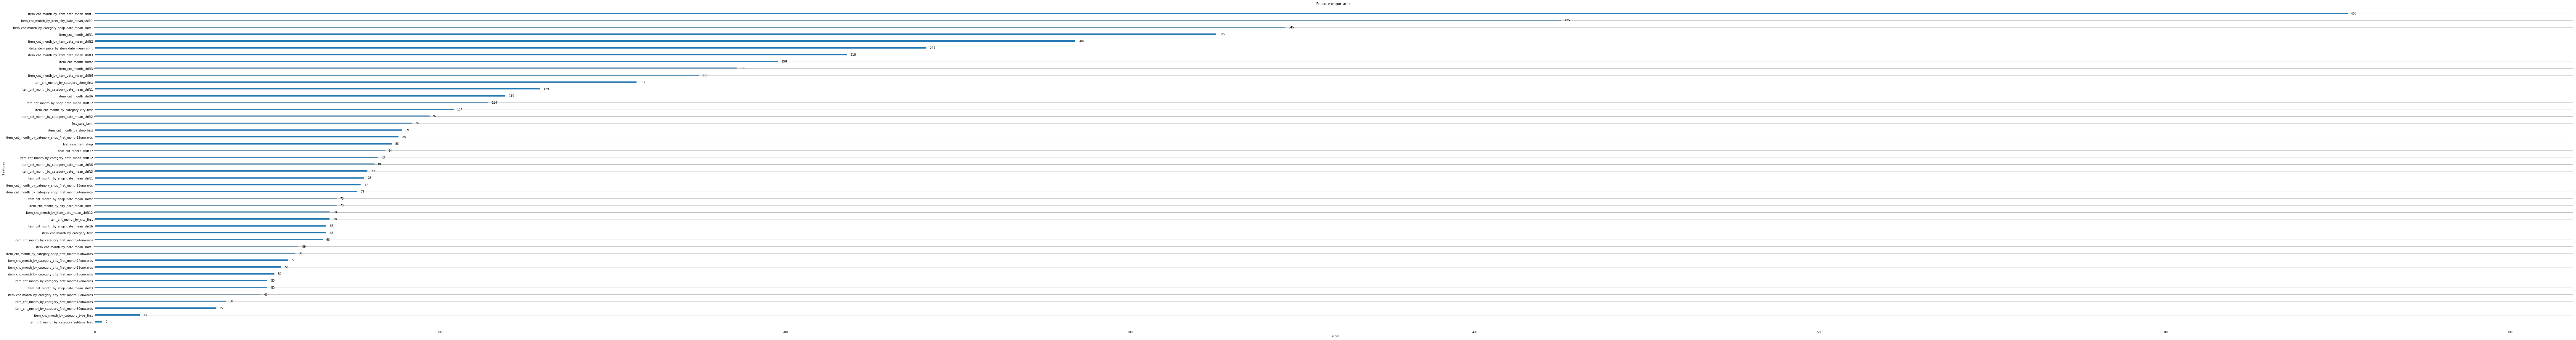

In [101]:
# plot the feature importances
fig, axes = plt.subplots(figsize=(150 , 20))
xgb.plot_importance(model_xgbreg, ax=axes)

In [102]:
# model selection
model_xgbreg_exist = model_xgbreg

In [103]:
# memory clean-up
del x_train, x_validate, y_train, y_validate
gc.collect()

12

In [104]:
# select the important features
x = df_block[(df_block['first_sale_item'] == 0) & (df_block['date_block_num'] >= 30) & (df_block['date_block_num'] <= 33)].drop(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_category_id', 'year', 'month', 'day', 'city_code', 'type_code', 'subtype_code'] + [col for col in df_block.columns if col.startswith('item_price')], axis=1)
y = df_block.loc[(df_block['first_sale_item'] == 0) & (df_block['date_block_num'] >= 30) & (df_block['date_block_num'] <= 33), 'item_cnt_month']

In [105]:
# perform train-test (validate) split
x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.25, random_state=58)

In [106]:
# memory clean-up
del x, y
gc.collect()

10

In [107]:
# xgboost regression model setup
model_xgbreg = xgb.XGBRegressor(max_depth=8, learning_rate=0.3, n_estimators=500, objective='reg:linear', booster='gbtree', gamma=0.1, min_child_weight=300, subsample=0.8, colsample_bytree=0.8, reg_alpha=0, reg_lambda=1, random_state=58)

# xgboost regression model fit
model_xgbreg.fit(x_train, y_train, eval_set=[(x_train, y_train), (x_validate, y_validate)], early_stopping_rounds=10, verbose=True)

# xgboost regression model prediction
model_xgbreg_ypredict = model_xgbreg.predict(x_validate).clip(0 ,20)

# xgboost regression model metrics
model_xgbreg_rmse = mean_squared_error(y_validate, model_xgbreg_ypredict) ** 0.5
print('xgboost regression\n  root mean squared error: %0.4f' %model_xgbreg_rmse)

/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[12:51:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.81798	validation_1-rmse:1.88777
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.73672	validation_1-rmse:1.79701
[2]	validation_0-rmse:1.69341	validation_1-rmse:1.75062
[3]	validation_0-rmse:1.66664	validation_1-rmse:1.72401
[4]	validation_0-rmse:1.65086	validation_1-rmse:1.70698
[5]	validation_0-rmse:1.64135	validation_1-rmse:1.69715
[6]	validation_0-rmse:1.63512	validation_1-rmse:1.69041
[7]	validation_0-rmse:1.62888	validation_1-rmse:1.68468
[8]	validation_0-rmse:1.62573	validation_1-rmse:1.68086
[9]	validation_0-rmse:1.62298	validation_1-rmse:1.6811
[10]	validation_0-rmse:1.62108	validation_1-rmse:1.6787
[11]	validation_0-rmse:1.61946	validation_1-rmse:1.67725
[12]	validation_0-rmse:1.61739	validation_

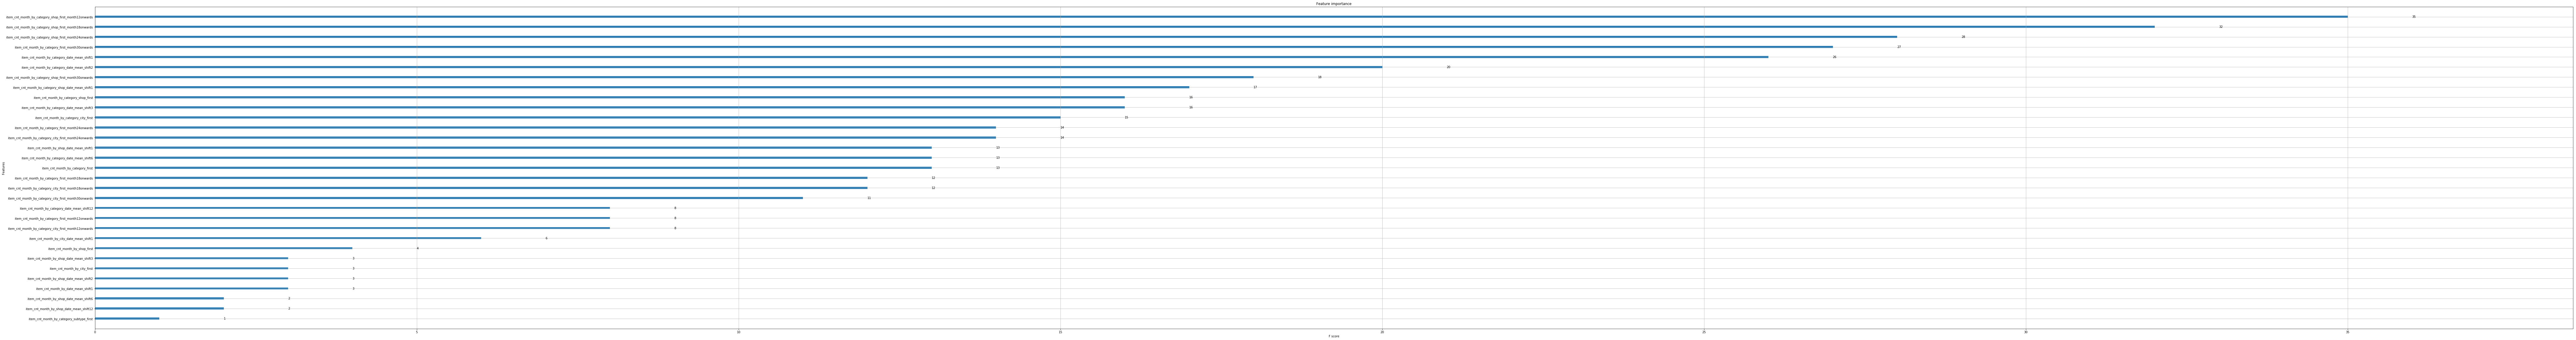

In [108]:
# plot the feature importances
fig, axes = plt.subplots(figsize=(150 , 20))
xgb.plot_importance(model_xgbreg, ax=axes)

In [109]:
# model selection
model_xgbreg_first = model_xgbreg

In [110]:
# memory clean-up
del x_train, x_validate, y_train, y_validate
gc.collect()

7

> **Supply or submit the results**

Our submission to the competition site Kaggle is ready. Any suggestions to improve our score are welcome.

In [111]:
# feature extraction: fix the duplicated shop id
df_test.loc[df_test['shop_id'] == 0, 'shop_id'] = 57
df_test.loc[df_test['shop_id'] == 1, 'shop_id'] = 58
df_test.loc[df_test['shop_id'] == 11, 'shop_id'] = 10

In [112]:
# model selection
final_model = [model_xgbreg_exist, model_xgbreg_first]

# prepare testing data and compute the observed value for model_exist
x_test = df_block[(df_block['first_sale_item'] != 0) & (df_block['date_block_num'] == 34)].drop(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_category_id', 'year', 'month', 'day', 'city_code', 'type_code', 'subtype_code'] + [col for col in df_block.columns if col.startswith('item_price')], axis=1)
y_test = pd.DataFrame({'item_cnt_month': final_model[0].predict(x_test).clip(0 ,20), 'shop_id': df_block.loc[(df_block['first_sale_item'] != 0) & (df_block['date_block_num'] == 34), 'shop_id'], 'item_id': df_block.loc[(df_block['first_sale_item'] != 0) & (df_block['date_block_num'] == 34), 'item_id']}, index=x_test.index)
y_submit_exist = pd.merge(y_test, df_test[['ID', 'shop_id', 'item_id']], how='left', on=['shop_id', 'item_id'])

# prepare testing data and compute the observed value for model_first
x_test = df_block[(df_block['first_sale_item'] == 0) & (df_block['date_block_num'] == 34)].drop(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'item_category_id', 'year', 'month', 'day', 'city_code', 'type_code', 'subtype_code'] + [col for col in df_block.columns if col.startswith('item_price')], axis=1)
y_test = pd.DataFrame({'item_cnt_month': final_model[1].predict(x_test).clip(0 ,20), 'shop_id': df_block.loc[(df_block['first_sale_item'] == 0) & (df_block['date_block_num'] == 34), 'shop_id'], 'item_id': df_block.loc[(df_block['first_sale_item'] == 0) & (df_block['date_block_num'] == 34), 'item_id']}, index=x_test.index)
y_submit_first = pd.merge(y_test, df_test[['ID', 'shop_id', 'item_id']], how='left', on=['shop_id', 'item_id'])

# merge submission
y_submit = pd.concat([y_submit_exist, y_submit_first], ignore_index=True)

In [113]:
# submit the results
out = pd.DataFrame({'ID': y_submit['ID'], 'item_cnt_month': y_submit['item_cnt_month']})
out.to_csv('submission.csv', index=False)